In [125]:
import matplotlib.pyplot as plt
from rnpe.utils import get_manual_legend, pairplot
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
import string

sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_style('whitegrid', {'font.family':'Times New Roman', 'font.serif':'serif', "font.size": 11})
colors = ["#072D41", "#5ac5e0", "#ECA918", "#359735"]  # Using slightly brighter blue here for better contrast
plt.rcParams['axes.axisbelow'] = True


### Helper function

In [135]:
def rescale_results(res):
    x_mean, x_std = res["scales"]["x_mean"], res["scales"]["x_std"]
    theta_mean, theta_std = res["scales"]["theta_mean"], res["scales"]["theta_std"]

    res["data"]["x"] = res["data"]["x"] * x_std + x_mean
    res["data"]["y"] = res["data"]["y"] * x_std + x_mean
    res["data"]["theta"] = res["data"]["theta"] * theta_std + theta_mean
    res["data"]["theta_true"] = res["data"]["theta_true"] * theta_std + theta_mean
    res["mcmc_samples"]["x"] = res["mcmc_samples"]["x"] * x_std + x_mean

    res["posterior_samples"]["NPE"] = res["posterior_samples"]["NPE"] * theta_std + theta_mean
    res["posterior_samples"]["Robust NPE"] = res["posterior_samples"]["Robust NPE"] * theta_std + theta_mean

def misspecified_barplot(res, ax):
    "Plots posterior misspecification probabilities"
    misspecified = res["mcmc_samples"]["misspecified"].mean(axis=0)
    order = np.argsort(misspecified)
    misspecified = misspecified[order]
    names = [res["names"]["x"][i] for i in order]
    sns.barplot(x=misspecified, y=names, color=colors[2], ax=ax)
    ax.set_xlabel("Posterior Misspecification \nProbability")
    ax.set_xticks([0, 0.5, 1])
    ax.tick_params(axis="y", direction="out", pad=0)


def missecified_density(res, ax, n = 10000):
    "Plots a density of the denoised samples for the most misspecified summary statistic"
    n = 10000
    idx = res["mcmc_samples"]["misspecified"].mean(axis=0).argmax()
    name = res["names"]["x"][idx]

    df = pd.DataFrame({
            "Simulations": np.random.permutation(res["data"]["x"])[:n, idx],
            "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n, idx]
        })

    df = df.melt(value_name=name, var_name="Source")
    df["Source"] = pd.Categorical(df["Source"], ["Simulations", "Denoised"])

    sns.kdeplot(
        x = name,
        hue="Source",
        ax=ax,
        data=df,
        palette=[colors[0], colors[2]],
    )
    ax.set_yticks([])
    ax.get_legend().set_title(None)
    ax.axvline(res["data"]["y"][idx], color=colors[-1]) # True


### SIR example

In [136]:
# Read in and format data
f_name = f"../results/sirsde/2.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)

pretty_x_names = {
    "log_mean": "Mean",
    "log_median": "Median",
    "log_max_infections": "Max",
    "log_max_infections_day": "Max Day",
    "log_half_total_reached_at": "Half Day",
    "autocor_lag1": "Autocor",
}

pretty_theta_names = {
    "beta": r"$\beta$",
    "gamma": r"$\gamma$"
}

res["names"]["x"] = [pretty_x_names[n] for n in res["names"]["x"]]
res["names"]["theta"] = [pretty_theta_names[n] for n in res["names"]["theta"]]

rescale_results(res)

In [133]:
# Dataframe for posteriors
def supported_only(theta):
    a = theta[:, 0] > theta[:, 1]
    b = theta[:, 0] < 0.5
    return theta[a & b]

thetas_d = {
    "Prior": res["data"]["theta"],
    "NPE": supported_only(res["posterior_samples"]["NPE"]),
    "RNPE": supported_only(res["posterior_samples"]["Robust NPE"])
    }

thetas = []
for source, samples in thetas_d.items():
    thetas.append(
        pd.DataFrame({
            r"$\beta$": samples[:, 0],
            r"$\gamma$": samples[:, 1],
            "Source": source
        })
    )

thetas = pd.concat(thetas)


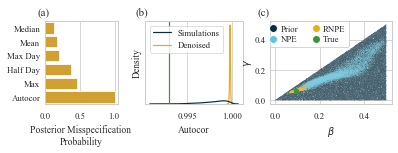

In [137]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(5.5, 2), gridspec_kw={'width_ratios': [0.6, 0.8, 1]})
plt. subplots_adjust()

misspecified_barplot(res, ax[0]) # a
missecified_density(res, ax[1]) # b

# plot c
sns.scatterplot(
    x=r"$\beta$",
    y=r"$\gamma$",
    data=thetas,
    hue="Source",
    ax=ax[2],
    s=0.2,
    palette=[colors[0], colors[1], colors[2]],
    rasterized=True
)
ax[2].scatter(x=res["data"]["theta_true"][0], y=res["data"]["theta_true"][1], color=colors[-1])
ax[2].get_legend().set_title(None)
handles = get_manual_legend(["Prior", "NPE", "RNPE", "True"], colors)
ax[2].legend(handles=handles, borderaxespad=0, loc="upper left", ncol=2, handlelength=0, labelspacing=0.3, framealpha=1)
ax[2].tick_params(axis="y", direction="out", pad=0)
ax[2].set_ylabel(ax[2].get_ylabel(), labelpad=0)

for n, ax in enumerate(ax):
    ax.text(-0.1, 1.08, f"({string.ascii_lowercase[n]})", transform=ax.transAxes, 
            size=11)
plt. subplots_adjust(left=0.115,
                    bottom=0.3, 
                    right=0.99, 
                    top=0.875, 
                    wspace=0.28)
plt.savefig("../results/plots/sir_example.pdf", dpi=600)

### CS example

In [144]:
for i in range(20):
    f_name = f"../results/cancer/{i}.pickle"
    with open(f_name, "rb") as f:
        res = pickle.load(f)
    print(res["metrics"]["NPE"]["hpd"])

99.98999834060669
100.0
98.51999878883362
89.58999514579773
97.2599983215332
99.60999488830566
75.3499984741211
95.95999717712402
88.40000033378601
83.66999626159668
100.0
45.089998841285706
85.92999577522278
99.94999766349792
78.33999991416931
98.74999523162842
99.90999698638916
99.65999722480774
100.0
99.29999709129333


In [145]:
# Read in and format data
f_name = f"../results/cancer/1.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)

pretty_theta_names = {
    "Cancer Parent Rate": r"$\lambda_p$",
    "Cancer Daughter Rate": r"$\lambda_d$",
    "Cell Rate": r"$\lambda_c$"
}
res["names"]["theta"] = [pretty_theta_names[n] for n in res["names"]["theta"]]

rescale_results(res)

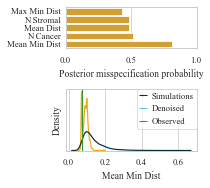

In [146]:
# Plot
fig, ax = plt.subplots(2, 1, figsize=(3, 2.7), gridspec_kw={'height_ratios': [0.4, 0.6]})
plt. subplots_adjust()

misspecified_barplot(res, ax[0]) # a
ax[0].set_xlabel("Posterior misspecification probability")
missecified_density(res, ax[1]) # b
handles = get_manual_legend(["Simulations", "Denoised", "Observed"], [colors[0], colors[1], colors[-1]], marker="_")
ax[1].legend(handles=handles, borderaxespad=0 , handlelength=0.4)
plt.tight_layout()

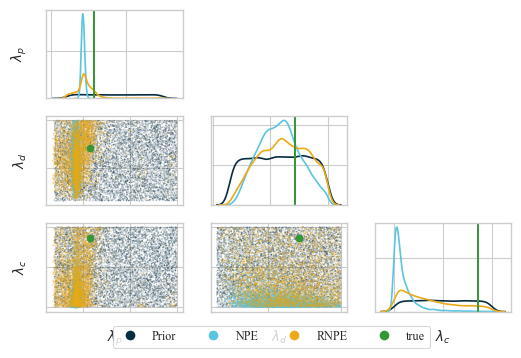

In [148]:
# Plot posterior pairplot?
# Dataframe for posteriors

thetas = {
    "Prior": res["data"]["theta"],
    "NPE": res["posterior_samples"]["NPE"],
    "RNPE": res["posterior_samples"]["Robust NPE"]
    }

p = pairplot(
    thetas, res["data"]["theta_true"],
    col_names = res["names"]["theta"],
    colors = colors,
    array_point_size=1)


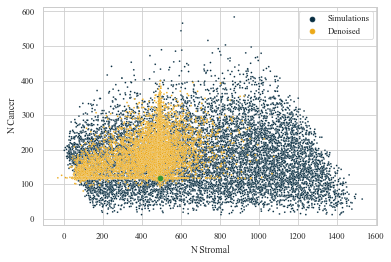

In [35]:

# def denosied_scatter(res, ax, n=10000):
#     "Plot the two most misspecified summary statisitics ag"
#     idx = res["mcmc_samples"]["misspecified"].mean(axis=0).argsort()[-2:]
#     names = [res["names"]["x"][i] for i in idx] 

#     denoised = {
#         "Simulations": np.random.permutation(res["data"]["x"])[:n],
#         "Denoised": np.random.permutation(res["mcmc_samples"]["x"][:n])
#     }

#     df = []
#     for k, v in denoised.items():
#         df.append(
#             pd.DataFrame({
#                 names[0]: v[:, idx[0]],
#                 names[1]: v[:, idx[1]],
#                 "Source": k
#             }   
#             )
#         )
#     df = pd.concat(df)

#     sns.scatterplot(
#         x=names[0],
#         y=names[1],
#         data=df,
#         hue="Source",
#         ax=ax,
#         s=3,
#         palette=[colors[0], colors[1]],
#         rasterized=True
#     )
#     ax.scatter(x=res["data"]["y"][idx[0]], y=res["data"]["y"][idx[1]], color=colors[-1])
#     ax.get_legend().set_title(None)

# fig, ax = plt.subplots()
# denosied_scatter(res, ax)


In [9]:
# Read in and format data
f_name = f"../results/cancer/0.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)

rescale_results(res)
misspecified = res["mcmc_samples"]["misspecified"].mean(axis=0)
order = np.argsort(misspecified)
misspecified = misspecified[order]
names = [res["names"]["x"][i] for i in order]
n = 10000

# autocor_idx = res["names"]["x"].index("autocor_lag1")
# denoised = pd.DataFrame({
#         "Simulations": np.random.permutation(res["data"]["x"])[:n, autocor_idx],
#         "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n, autocor_idx]
#     })

# denoised = denoised.melt(value_name="Autocor", var_name="Source")
# denoised["Source"] = pd.Categorical(denoised["Source"], ["Simulations", "Denoised"])

thetas_d = {
    "Prior": res["data"]["theta"],
    "NPE": res["posterior_samples"]["NPE"],
    "RNPE": res["posterior_samples"]["Robust NPE"]
    }

thetas = []
for source, samples in thetas_d.items():
    thetas.append(
        pd.DataFrame({
            r"$\beta$": samples[:, 0],
            r"$\gamma$": samples[:, 1],
            "Source": source
        })
    )

thetas = pd.concat(thetas)


In [ ]:
# Scatter
denoised_idxs = [res["names"]["x"].index(s) for s in ["N Stromal", "N Cancer"]]

denoised = {
    "Simulations": np.random.permutation(res["data"]["x"])[:n],
    "Denoised": np.random.permutation(res["mcmc_samples"]["x"][:n])
}

df = []
for x_name in ["N Stromal", "N Cancer"]:
    for k, v in denoised.items():
        df.append(
            pd.DataFrame(
                
            )
        )


denoised = pd.DataFrame({
        "Simulations": np.random.permutation(res["data"]["x"])[:n, autocor_idx],
        "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n, autocor_idx]
    })

denoised = denoised.melt(value_name="Autocor", var_name="Source")
denoised["Source"] = pd.Categorical(denoised["Source"], ["Simulations", "Denoised"])

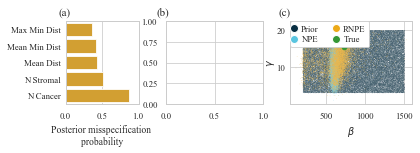

In [10]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(5.5, 2), gridspec_kw={'width_ratios': [0.6, 0.8, 1]})
plt. subplots_adjust()

# plot a (bar)
sns.barplot(x=misspecified, y=names, color=colors[1], ax=ax[0])
ax[0].set_xlabel("Posterior misspecification \nprobability")
ax[0].set_xticks([0, 0.5, 1])

# TODO needs more axis ticks

# plot b (Scatter denoised)

sns.scatterplot(
    x=r"$\beta$",
    y=r"$\gamma$",
    data=thetas,
    hue="Source",
    ax=ax[1],
    s=0.2,
    palette=[colors[0], colors[2], colors[1]],
    rasterized=True
)

# sns.kdeplot(
#     x = "Autocor",
#     hue="Source",
#     ax=ax[1],
#     data=denoised,
#     palette=[colors[0], colors[1]],
#     )
# ax[1].set_yticks([])
# ax[1].get_legend().set_title(None)
# ax[1].axvline(res["data"]["y"][autocor_idx], color=colors[-1]) # True
# handles = get_manual_legend(["Simulations", "Denoised", "Observed"], [colors[0], colors[1], colors[-1]], marker="_")
# ax[1].legend(handles=handles, borderaxespad=0, loc="upper left", handlelength=0.4, framealpha=1)

# plot c
sns.scatterplot(
    x=r"$\beta$",
    y=r"$\gamma$",
    data=thetas,
    hue="Source",
    ax=ax[2],
    s=0.2,
    palette=[colors[0], colors[2], colors[1]],
    rasterized=True
)
ax[2].scatter(x=res["data"]["theta_true"][0], y=res["data"]["theta_true"][1], color=colors[-1])
ax[2].get_legend().set_title(None)
handles = get_manual_legend(["Prior", "NPE", "RNPE", "True"], [colors[0], colors[2], colors[1], colors[-1]])
ax[2].legend(handles=handles, borderaxespad=0, loc="upper left", ncol=2, handlelength=0, labelspacing=0.3, framealpha=1)

ax[2].tick_params(axis="y", direction="out", pad=0)
ax[0].tick_params(axis="y", direction="out", pad=0)
ax[2].set_ylabel(ax[2].get_ylabel(), labelpad=0)

import string
for n, ax in enumerate(ax):
    ax.text(-0.1, 1.08, f"({string.ascii_lowercase[n]})", transform=ax.transAxes, 
            size=11)
plt. subplots_adjust(left=0.115,
                    bottom=0.3, 
                    right=0.99, 
                    top=0.875, 
                    wspace=0.28)
# plt.savefig("../results/plots/sir_example.pdf", dpi=600)

In [ ]:
pairplot()